# 2D Channel with Time-Dependent Boundary Conditions
#### This example demonstrates the simulation of a flow in a 2D channel in a closed rectangular domain using constant and time dependent boundary conditions. 

The flow is forced by an initial perturbation in the water elevation field centred in the middle of the channel. The model solves the Shallow Water Equations which are not expanded herein for brevity.
 
To run this example, it is necessary to install [firedrake](https://www.firedrakeproject.org/download.html) and [Thetis](https://thetisproject.org/download.html)

[Link to Tutorials on Thetis Website](https://thetisproject.org/documentation.html)

We begin with a number of imports. Note that we use `from thetis import *` which means that we do not need to prepend `thetis.` all the time. This also automatically includes a `from firedrake import *` so that we have access to the all the firedrake objects we saw yesterday such as `RectangleMesh`, `Function`, `FunctionSpace` etc. - without having to prepend `fd` as we did then.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from thetis import *

We create a rectangular mesh using the builtin Firedrake mesh utility. 
Our domain is 40 km long and 2 km wide, and we will generate 25 elements in the along-channel direction and 2 in the cross-channel direction:

In [2]:
lx = 40e3
ly = 2e3
nx = 25
ny = 2
mesh2d = RectangleMesh(nx, ny, lx, ly)

We can use the built in [plot](https://firedrakeproject.org/firedrake.html#firedrake.plot.plot) function of firedrake to visualise the mesh.

NameError: name 'triplot' is not defined

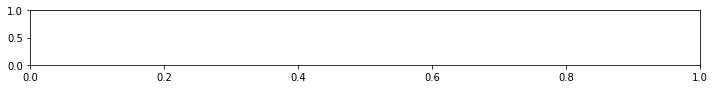

In [3]:
fig, ax = plt.subplots(figsize=(12,1))
triplot(mesh2d, axes=ax);

Next we define a bathymetry function in this domain using continuous linear elements, and set the bathymetry to a constant 20 m depth:

In [4]:
P1_2d = FunctionSpace(mesh2d, 'CG', 1)
bathymetry_2d = Function(P1_2d, name='Bathymetry')
depth = 20.0
bathymetry_2d.assign(depth);

We are now ready to create a 2D solver object. This object can be used to solve the depth-averaged shallow water equations controlled by some options that can be set by the user.

In [5]:
solver_obj = solver2d.FlowSolver2d(mesh2d, bathymetry_2d)
options = solver_obj.options

First we set the options for the total duration and export intervals. The latter determines how frequently Thetis writes output files.

In [6]:
options.simulation_end_time = 12 * 3600
options.simulation_export_time = 1200.0

We also select the directory in which the output files will appear, which will be created automatically if it does not yet exist:

In [7]:
options.output_directory = 'outputs_2d_channel'

The standard output of Thetis is in the form of a `.pvd` file with an associated series of `.vtu` files (and `.pvtu` when running in parallel). For visualisation we recommend the program [paraview](https://paraview.org). This program is however not available inside this jupyter environment. Therefore we will here use hdf5 output files instead, which can be used to read back in the solution in Firedrake and Thetis (unlike the `.pvd`+`.vtu` output which cannot be read back in by Firedrake). This output can also be used as checkpoints, from which Thetis can be restarted. Here we will use the hdf5 output to read it back into Firedrake and plot it.

We select which fields to output (`'elev_2d'` for elevations and `'uv_2d'` for the 2d velocity vector):

In [8]:
options.fields_to_export_hdf5 = ['elev_2d', 'uv_2d']

Next we define the time integrator, and set the time step, which can be chosen freely since Crank-Nicolson is unconditionally stable. Of course it will influence the accuracy of the simulation.

In [9]:
options.timestepper_type = 'CrankNicolson'
options.timestep = 200.0

### Boundary conditions
We will force the model with a prescribed tidal elevation on the right side of the domain ($x=40 $km), and keep a constant elevation on the left ($x=0$).

Boundary conditions are defined for each external boundary using their ID.

In this example we are using a [RectangleMesh()](https://firedrakeproject.org/firedrake.html#firedrake.utility_meshes.RectangleMesh) which assigns IDs 1, 2, 3, and 4 for the four sides of the rectangle:

In [10]:
left_bnd_id = 1
right_bnd_id = 2

At each boundary we can define the external value of the prognostic variables, i.e. in this case the water elevation and velocity.The value should be either a Firedrake [Constant](https://firedrakeproject.org/firedrake.html#firedrake.constant.Constant) or a Firedrake [Function](https://firedrakeproject.org/firedrake.html#firedrake.function.Function) (in case the boundary condition is not uniform in space).

We store the boundary conditions in a dictionary.


In [11]:
swe_bnd = {}
swe_bnd[left_bnd_id] = {'elev': Constant(0.0)}

Above we set the water elevation (using key `'elev'`) on the left bounday. Alternatively, we could also prescribe the normal velocity (with key `'un'`), the full 2D velocity vector (`'uv'`) or the total flux through the boundary (`'flux'`). For all supported boundary conditions, see module [shallowwater_eq](https://thetisproject.org/thetis.html#module-thetis.shallowwater_eq).

In order to set time-dependent boundary conditions we first define a python function that evaluates the time dependent variable:

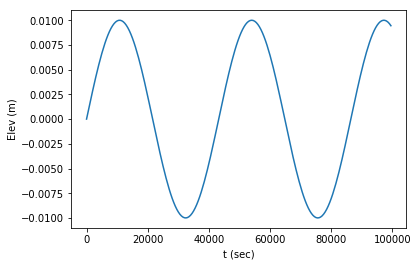

In [12]:
tide_amp = 0.01  # amplitude of the tide
tide_t = 12 * 3600.  # period of the tide

def tidal_elevation(simulation_time):
    """Time-dependent tidal elevation"""
    elev = tide_amp * sin(2 * pi * simulation_time / tide_t)
    return elev


plt.plot(np.arange(0,100000,500),[tidal_elevation(i) for i in np.arange(0,100000,500)])
plt.ylabel('Elev (m)')
plt.xlabel('t (sec)');

We then create a `Constant` object with the initial value, and assign it to the left boundary:

In [13]:
tide_elev_const = Constant(tidal_elevation(0))
swe_bnd[right_bnd_id] = {'elev': tide_elev_const}

Boundary conditions are now complete, and we assign them to the solver object:

In [14]:
solver_obj.bnd_functions['shallow_water'] = swe_bnd

Note that if boundary conditions are not assigned for some boundaries (the lateral boundaries 3 and 4 in this case), Thetis assumes impermeable land conditions.

The only missing piece is to add a mechanism that re-evaluates the boundary condition as the simulation progresses. For this purpose we use the optional update_forcings argument of the [iterate()](https://thetisproject.org/thetis.html#thetis.solver2d.FlowSolver2d.iterate) method. update_forcings is a python function that updates all time dependent [Constants](https://firedrakeproject.org/firedrake.html#firedrake.constant.Constant) or [Functions](https://firedrakeproject.org/firedrake.html#firedrake.function.Function) used to force the model. In this case we only need to update `tide_elev_const`:

In [15]:
def update_forcings(t_new):
    """Callback function that updates all time dependent forcing fields"""
    uv, elev = solver_obj.fields.solution_2d.split()
    tide_elev_const.assign(tidal_elevation(t_new))

Finally we pass this callback to the time iterator and run the model

In [16]:
solver_obj.iterate(update_forcings=update_forcings)

Using default SIPG parameters
dt = 200.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=   1200.00 eta norm:     6.5453 u norm:     4.5832  2.06
    2    12 T=   2400.00 eta norm:    17.3241 u norm:    12.1339  0.15
    3    18 T=   3600.00 eta norm:    29.9394 u norm:    22.0483  0.12
    4    24 T=   4800.00 eta norm:    38.0665 u norm:    36.7198  0.13
    5    30 T=   6000.00 eta norm:    38.4731 u norm:    55.5626  0.13
    6    36 T=   7200.00 eta norm:    41.8948 u norm:    77.3546  0.13
    7    42 T=   8400.00 eta norm:    49.0878 u norm:   101.4219  0.13
    8    48 T=   9600.00 eta norm:    55.3362 u norm:   126.8069  0.13
    9    54 T=  10800.00 eta norm:    55.2865 u norm:   153.0439  0.14
   10    60 T=  12000.00 eta norm:    48.0631 u norm:   179.1980  0.12
   11    66 T=  13200.00 eta norm:    45.6190 u norm:   204.4493  0.11
   12    72 T=  14400.00 eta norm:    45.5563 u norm:   228.1257  0.12

While the model is running, Thetis prints some statistics on the command line:
 
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=   1200.00 eta norm:     6.5453 u norm:     4.5832  8.49
    2    12 T=   2400.00 eta norm:    17.3241 u norm:    12.1339  0.16
    3    18 T=   3600.00 eta norm:    29.9394 u norm:    22.0483  0.16
     ...
 
 The first column is the export index, the second one the number of executed
 time steps, followed by the simulation time. ``eta norm`` and ``u norm`` are
 the L2 norms of the elevation and depth averaged velocity fields, respectively.
 The last column stands for the (approximate) wall-clock time between exports.
 
 The simulation terminates once the end time is reached.

### Visualising the output
Information on how to visualise results can be found here [outputs and visualization page](https://thetisproject.org/outputs_and_visu.html).

Here we will use the hdf5 output (also used for checkpointing) to read back in the solution at different timesteps and plot it using Firedrake. First we need an elevation function, and a velocity function from the same function space that we used in the simulation:

In [17]:
elev = Function(solver_obj.function_spaces.H_2d, name='elev_2d')
uv = Function(solver_obj.function_spaces.U_2d, name='uv_2d')

The following code opens the 9th output. We use `os.path.join` to combine the different parts (base outputdirectory, hdf5 sub directory, and actual filename) into a filename.

In [18]:
idx = 9 # which hdf5 do we want to open
filename =  os.path.join(options.output_directory, 'hdf5','Elevation2d_%05d' % idx)
dc = DumbCheckpoint(filename, mode=FILE_READ)

Now we can read the solution into the `elev` and plot it:

NameError: name 'tricontourf' is not defined

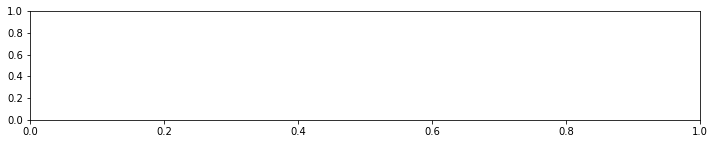

In [19]:
dc.load(elev)
fig, ax = plt.subplots(figsize=(12,2))
tricontourf(elev, axes=ax, cmap=matplotlib.cm.coolwarm, levels=50)
plt.axis('equal');

In the same way we can also load and plot the velocity field:

NameError: name 'quiver' is not defined

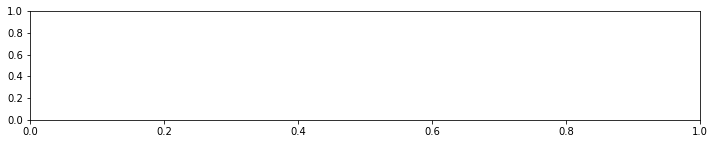

In [20]:
idx = 9 # which hdf5 do we want to open
filename = os.path.join(options.output_directory, 'hdf5','Velocity2d_%05d' % idx)
dc = DumbCheckpoint(filename, mode=FILE_READ)
dc.load(uv)
fig, ax = plt.subplots(figsize=(12,2))
quiver(uv, axes=ax, cmap=matplotlib.cm.coolwarm)
plt.axis('equal');

The following plots the elevations of all exported timesteps:

In [ ]:
last_idx = solver_obj.i_export
matplotlib.rcParams['figure.max_open_warning'] = last_idx+1  # avoid warning
for idx in range(last_idx+1):
    filename =  os.path.join(options.output_directory, 'hdf5','Elevation2d_%05d' % idx)
    dc = DumbCheckpoint(filename, mode=FILE_READ)
    dc.load(elev)
    dc.close()
    fig, ax = plt.subplots(figsize=(16,1))
    tricontourf(elev, axes=ax, cmap=matplotlib.cm.coolwarm, levels=50)
    # Firedrake sets an automatic colorbar range which therefore changes per timestep
    # instead, we want to fix it:
    cbar = fig.axes[0].collections[-1].set_clim(-tide_amp, tide_amp)
    plt.axis('equal')

## Exercises:
In the exercises we will try to make a number of changes to the above setup. For ease of use we have copied all the steps above in a single cell, so that you can easily repeat them and make your own adaptations:

In [28]:
# setup the mesh:
lx = 40e3
ly = 2e3
nx = 25
ny = 2
mesh2d = RectangleMesh(nx, ny, lx, ly)

# setup the bathymetry:
P1_2d = FunctionSpace(mesh2d, 'CG', 1)
bathymetry_2d = Function(P1_2d, name='Bathymetry')
depth = 20.0
bathymetry_2d.assign(depth);

# setup the solver object and set some options
solver_obj = solver2d.FlowSolver2d(mesh2d, bathymetry_2d)
options = solver_obj.options

options.simulation_end_time = 12 * 3600
options.simulation_export_time = 1200.0

options.output_directory = 'outputs_2d_channel'
options.fields_to_export_hdf5 = ['elev_2d', 'uv_2d']

options.timestepper_type = 'CrankNicolson'
options.timestep = 200.0

# setup boundary conditions:
left_bnd_id = 1
right_bnd_id = 2
swe_bnd = {}
swe_bnd[left_bnd_id] = {'elev': Constant(0.0)}

tide_amp = 0.01  # amplitude of the tide
tide_t = 12 * 3600.  # period of the tide

def tidal_elevation(simulation_time):
    """Time-dependent tidal elevation"""
    elev = tide_amp * sin(2 * pi * simulation_time / tide_t)
    return elev

tide_elev_const = Constant(tidal_elevation(0))
swe_bnd[right_bnd_id] = {'elev': tide_elev_const}

solver_obj.bnd_functions['shallow_water'] = swe_bnd

def update_forcings(t_new):
    """Callback function that updates all time dependent forcing fields"""
    uv, elev = solver_obj.fields.solution_2d.split()
    tide_elev_const.assign(tidal_elevation(t_new))

solver_obj.iterate(update_forcings=update_forcings)

Using default SIPG parameters
dt = 200.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=   1200.00 eta norm:     6.5453 u norm:     4.5832  1.41
    2    12 T=   2400.00 eta norm:    17.3241 u norm:    12.1339  0.13
    3    18 T=   3600.00 eta norm:    29.9394 u norm:    22.0483  0.11
    4    24 T=   4800.00 eta norm:    38.0665 u norm:    36.7198  0.12
    5    30 T=   6000.00 eta norm:    38.4731 u norm:    55.5626  0.12
    6    36 T=   7200.00 eta norm:    41.8948 u norm:    77.3546  0.13
    7    42 T=   8400.00 eta norm:    49.0878 u norm:   101.4219  0.13
    8    48 T=   9600.00 eta norm:    55.3362 u norm:   126.8069  0.13
    9    54 T=  10800.00 eta norm:    55.2865 u norm:   153.0439  0.12
   10    60 T=  12000.00 eta norm:    48.0631 u norm:   179.1980  0.11
   11    66 T=  13200.00 eta norm:    45.6190 u norm:   204.4493  0.14
   12    72 T=  14400.00 eta norm:    45.5563 u norm:   228.1257  0.12

Try to make the following changes:

1. apply a prescribed velocity boundary condition at the open boundary instead of a prescribed elevation

In [29]:
# setup the mesh:
lx = 40e3
ly = 2e3
nx = 25
ny = 2
mesh2d = RectangleMesh(nx, ny, lx, ly)

# setup the bathymetry:
P1_2d = FunctionSpace(mesh2d, 'CG', 1)
bathymetry_2d = Function(P1_2d, name='Bathymetry')
depth = 20.0
bathymetry_2d.assign(depth);

# setup the solver object and set some options
solver_obj = solver2d.FlowSolver2d(mesh2d, bathymetry_2d)
options = solver_obj.options

options.simulation_end_time = 12 * 3600
options.simulation_export_time = 1200.0

options.output_directory = 'outputs_2d_channel_vel'
options.fields_to_export_hdf5 = ['elev_2d', 'uv_2d']

options.timestepper_type = 'CrankNicolson'
options.timestep = 200.0

# setup boundary conditions:
left_bnd_id = 1
right_bnd_id = 2
swe_bnd = {}
swe_bnd[left_bnd_id] = {'elev': Constant(0.0)}

vel_amp = 1  # velocity of the tide
tide_t = 12 * 3600.  # period of the tide

def tidal_vel(simulation_time):
    """Time-dependent tidal elevation"""
    vel = vel_amp * sin(2 * pi * simulation_time / tide_t)
    return vel

vel_const = Constant(tidal_elevation(0))
swe_bnd[right_bnd_id] = {'uv': as_vector((vel_const, 0))}

solver_obj.bnd_functions['shallow_water'] = swe_bnd

def update_forcings(t_new):
    """Callback function that updates all time dependent forcing fields"""
    uv, elev = solver_obj.fields.solution_2d.split()
    vel_const.assign(tidal_vel(t_new))

solver_obj.iterate(update_forcings=update_forcings)

Using default SIPG parameters
dt = 200.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=   1200.00 eta norm:   927.4638 u norm:   650.5541  2.10
    2    12 T=   2400.00 eta norm:  2438.3580 u norm:  1716.0336  0.20
    3    18 T=   3600.00 eta norm:  4190.5129 u norm:  3101.1667  0.19
    4    24 T=   4800.00 eta norm:  5314.3208 u norm:  5142.1805  0.20
    5    30 T=   6000.00 eta norm:  5156.0042 u norm:  7704.2167  0.15
    6    36 T=   7200.00 eta norm:  3653.4361 u norm:  9759.3842  0.12
    7    42 T=   8400.00 eta norm:  1306.8256 u norm: 10942.3863  0.13
    8    48 T=   9600.00 eta norm:  1316.7025 u norm: 11140.0771  0.12
    9    54 T=  10800.00 eta norm:  3137.4179 u norm: 10287.1437  0.12
   10    60 T=  12000.00 eta norm:  3654.7289 u norm:  8673.6861  0.12
   11    66 T=  13200.00 eta norm:  2912.9389 u norm:  7286.7235  0.12
   12    72 T=  14400.00 eta norm:  1426.2944 u norm:  6320.7220  0.12

2. change the bathymetry to be spatially varying, for instance use:

In [30]:
x, y = SpatialCoordinate(mesh2d)
bathymetry_2d.interpolate(depth * (1-0.5*max_value(cos((x-lx/2)/lx*pi*2), 0)));

In [31]:
# setup the mesh:
lx = 40e3
ly = 2e3
nx = 25
ny = 2
mesh2d = RectangleMesh(nx, ny, lx, ly)

# setup the bathymetry:
P1_2d = FunctionSpace(mesh2d, 'CG', 1)
bathymetry_2d = Function(P1_2d, name='Bathymetry')
depth = 20.0

x, y = SpatialCoordinate(mesh2d)
bathymetry_2d.interpolate(depth * (1-0.5*max_value(cos((x-lx/2)/lx*pi*2), 0)))

# setup the solver object and set some options
solver_obj = solver2d.FlowSolver2d(mesh2d, bathymetry_2d)
options = solver_obj.options

options.simulation_end_time = 12 * 3600
options.simulation_export_time = 1200.0

options.output_directory = 'outputs_2d_channel_bath'
options.fields_to_export_hdf5 = ['elev_2d', 'uv_2d']

options.timestepper_type = 'CrankNicolson'
options.timestep = 200.0

# setup boundary conditions:
left_bnd_id = 1
right_bnd_id = 2
swe_bnd = {}
swe_bnd[left_bnd_id] = {'elev': Constant(0.0)}

tide_amp = 0.01  # amplitude of the tide
tide_t = 12 * 3600.  # period of the tide

def tidal_elevation(simulation_time):
    """Time-dependent tidal elevation"""
    elev = tide_amp * sin(2 * pi * simulation_time / tide_t)
    return elev

tide_elev_const = Constant(tidal_elevation(0))
swe_bnd[right_bnd_id] = {'elev': tide_elev_const}

solver_obj.bnd_functions['shallow_water'] = swe_bnd

def update_forcings(t_new):
    """Callback function that updates all time dependent forcing fields"""
    uv, elev = solver_obj.fields.solution_2d.split()
    tide_elev_const.assign(tidal_elevation(t_new))

solver_obj.iterate(update_forcings=update_forcings)

Using default SIPG parameters
dt = 200.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=   1200.00 eta norm:     6.5951 u norm:     4.5757  1.53
    2    12 T=   2400.00 eta norm:    18.0260 u norm:    12.4097  0.14
    3    18 T=   3600.00 eta norm:    30.3223 u norm:    22.9308  0.12
    4    24 T=   4800.00 eta norm:    38.5665 u norm:    37.5114  0.12
    5    30 T=   6000.00 eta norm:    41.4789 u norm:    57.6637  0.13
    6    36 T=   7200.00 eta norm:    41.6899 u norm:    80.2106  0.12
    7    42 T=   8400.00 eta norm:    49.5329 u norm:   104.7573  0.12
    8    48 T=   9600.00 eta norm:    56.6086 u norm:   131.8513  0.12
    9    54 T=  10800.00 eta norm:    56.2881 u norm:   158.7354  0.11
   10    60 T=  12000.00 eta norm:    51.6871 u norm:   185.7933  0.13
   11    66 T=  13200.00 eta norm:    45.8638 u norm:   212.6044  0.11
   12    72 T=  14400.00 eta norm:    44.7188 u norm:   236.6175  0.12

For now let's make sure the bathymetry is sufficiently deep, so that the total depth (including the free surface elevation) does not go negative! This avoids us having to deal with wetting and drying.

3. now let us try a bathymetry, where we do include wetting and drying. you will need the following additional option in your setup:

In [25]:
options.use_wetting_and_drying = True

To simulate the run up onto a beach, you could try the following bathymetry:

In [26]:
x, y = SpatialCoordinate(mesh2d)
bathymetry_2d.interpolate(depth * x/lx);

In addition you will need to remove the left boundary condition as it does no longer apply!

Using default SIPG parameters
dt = 200.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=   1200.00 eta norm:   640.5545 u norm:   479.5817 21.81
    2    12 T=   2400.00 eta norm:  1703.0442 u norm:  1304.6492  0.20
    3    18 T=   3600.00 eta norm:  3040.0605 u norm:  2417.8363  0.20


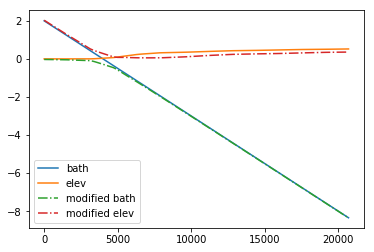

    4    24 T=   4800.00 eta norm:  4587.5683 u norm:  3930.1163  3.16
    5    30 T=   6000.00 eta norm:  6551.1593 u norm:  5821.7541  0.40
    6    36 T=   7200.00 eta norm:  8777.9340 u norm:  4613.4193  0.20
    7    42 T=   8400.00 eta norm: 10555.1223 u norm:  3222.3203  0.18


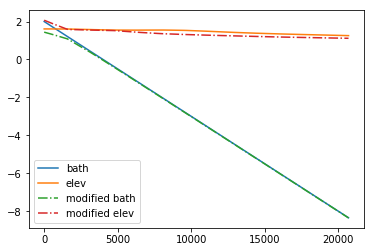

    8    48 T=   9600.00 eta norm: 11880.9722 u norm:  1631.9903  0.72
    9    54 T=  10800.00 eta norm: 12398.4621 u norm:   237.8233  0.17
   10    60 T=  12000.00 eta norm: 11848.6482 u norm:  1876.6537  0.19
   11    66 T=  13200.00 eta norm: 10290.0555 u norm:  3371.7892  0.21


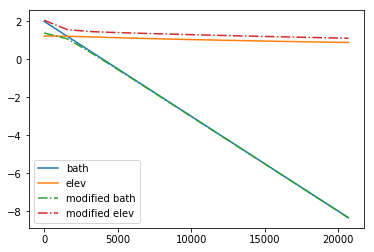

   12    72 T=  14400.00 eta norm:  8406.5794 u norm:  4522.1474  0.75
   13    78 T=  15600.00 eta norm:  6299.2034 u norm:  5064.4543  0.22
   14    84 T=  16800.00 eta norm:  4321.6198 u norm:  4408.2599  0.23
   15    90 T=  18000.00 eta norm:  3062.8302 u norm:  2440.2358  0.25


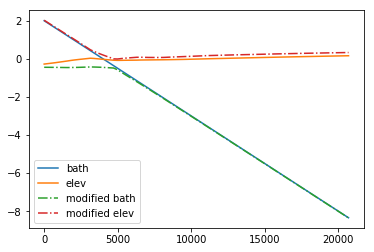

   16    96 T=  19200.00 eta norm:  1596.6149 u norm:  2730.0456  0.79
   17   102 T=  20400.00 eta norm:   717.8857 u norm:  1653.3687  0.27
   18   108 T=  21600.00 eta norm:   440.0770 u norm:   642.8634  0.22
   19   114 T=  22800.00 eta norm:   781.8222 u norm:   490.2141  0.20


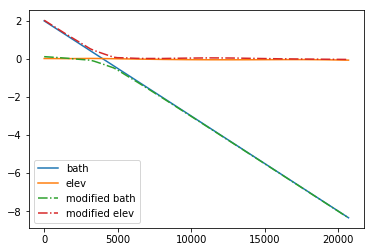

   20   120 T=  24000.00 eta norm:  1525.6405 u norm:  1265.0173  0.68
   21   126 T=  25200.00 eta norm:  2840.4705 u norm:  2322.9949  0.18
   22   132 T=  26400.00 eta norm:  4568.8034 u norm:  3632.3436  0.19
   23   138 T=  27600.00 eta norm:  6318.0416 u norm:  5075.5213  0.19


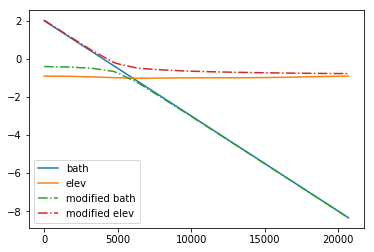

   24   144 T=  28800.00 eta norm:  8798.1916 u norm:  5600.2972  0.77
   25   150 T=  30000.00 eta norm: 11768.8547 u norm:  3792.2982  0.23
   26   156 T=  31200.00 eta norm: 13053.1063 u norm:  1835.3526  0.21
   27   162 T=  32400.00 eta norm: 12217.3491 u norm:  2353.0516  0.20


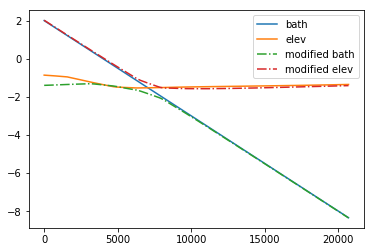

   28   168 T=  33600.00 eta norm: 11405.1119 u norm:  3184.1592  0.82
   29   174 T=  34800.00 eta norm: 10892.4887 u norm:  3707.5902  0.19
   30   180 T=  36000.00 eta norm:  7470.8912 u norm:  5503.7667  0.22
   31   186 T=  37200.00 eta norm:  5373.3420 u norm:  4431.1288  0.24


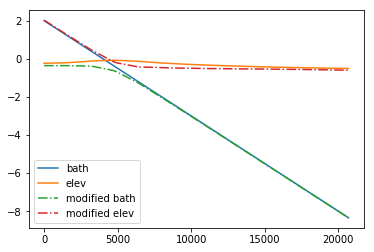

   32   192 T=  38400.00 eta norm:  4021.6563 u norm:  3036.6564  0.74
   33   198 T=  39600.00 eta norm:  3029.0171 u norm:  1338.7933  0.21
   34   204 T=  40800.00 eta norm:  1800.6448 u norm:  1766.0420  0.20
   35   210 T=  42000.00 eta norm:  1475.5739 u norm:   944.0811  0.20


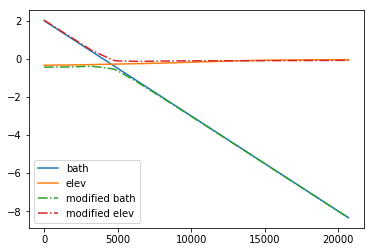

   36   216 T=  43200.00 eta norm:  1250.2411 u norm:   694.6113  0.71


In [32]:
import os

# setup the mesh:
lx = 40e3
ly = 2e3
nx = 25
ny = 2
mesh2d = RectangleMesh(nx, ny, lx, ly)

# setup the bathymetry:
P1_2d = FunctionSpace(mesh2d, 'CG', 1)
bathymetry_2d = Function(P1_2d, name='Bathymetry')
depth = 20.0

x, y = SpatialCoordinate(mesh2d)
bathymetry_2d.interpolate(depth * x/lx -2);

# setup the solver object and set some options
solver_obj = solver2d.FlowSolver2d(mesh2d, bathymetry_2d)
options = solver_obj.options

options.simulation_end_time = 12 * 3600
options.simulation_export_time = 1200.0

options.output_directory = 'outputs_2d_channel_wetting'
options.fields_to_export_hdf5 = ['elev_2d', 'uv_2d']

options.use_wetting_and_drying = True

options.timestepper_type = 'CrankNicolson'
options.timestep = 200.0

# setup boundary conditions:
left_bnd_id = 1
right_bnd_id = 2
swe_bnd = {}

tide_amp = 1  # amplitude of the tide
tide_t = 12 * 3600.  # period of the tide

def tidal_elevation(simulation_time):
    """Time-dependent tidal elevation"""
    elev = tide_amp * sin(2 * pi * simulation_time / tide_t)
    return elev

tide_elev_const = Constant(tidal_elevation(0))
swe_bnd[right_bnd_id] = {'elev': tide_elev_const}

solver_obj.bnd_functions['shallow_water'] = swe_bnd

# User-defined output: moving bathymetry and eta_tilde
wd_bathfile = File(os.path.join(options.output_directory, 'moving_bath.pvd'))
moving_bath = Function(P1_2d, name="moving_bath")
eta_tildefile = File(os.path.join(options.output_directory, 'eta_tilde.pvd'))
eta_tilde = Function(P1_2d, name="eta_tilde")

# user-specified export function
def export_func():
    wd_bath_displacement = solver_obj.depth.wd_bathymetry_displacement
    eta = solver_obj.fields.elev_2d
    moving_bath.project(bathymetry_2d + wd_bath_displacement(eta))
    wd_bathfile.write(moving_bath)
    eta_tilde.project(eta+wd_bath_displacement(eta))
    eta_tildefile.write(eta_tilde)

def update_forcings(t_new):
    """Callback function that updates all time dependent forcing fields"""
    uv, elev = solver_obj.fields.solution_2d.split()
    tide_elev_const.assign(tidal_elevation(t_new))
    
    if round(t_new, 2)%4800 == 0:
        xaxisthetis1 = []
        bathymetrythetis1 = []
        elevthetis = []
        moving_bath_list = []
        eta_tilde_list = []

        for i in np.linspace(0,(1.5*13800)-10, 80):
            xaxisthetis1.append(i)
            bathymetrythetis1.append(-bathymetry_2d.at([i, 600]))
            elevthetis.append(elev.at([i, 600])) 
            moving_bath_list.append(-moving_bath.at([i, 600]))
            eta_tilde_list.append(eta_tilde.at([i, 600]))
            
        plt.plot(xaxisthetis1, bathymetrythetis1, label = 'bath')
        plt.plot(xaxisthetis1, elevthetis, label = 'elev')
        plt.plot(xaxisthetis1, moving_bath_list, '-.', label = 'modified bath')
        plt.plot(xaxisthetis1, eta_tilde_list, '-.', label = 'modified elev')        
        plt.legend()
        #plt.savefig('image/test_' + str(t) + '.png')
        plt.show()

solver_obj.iterate(update_forcings=update_forcings, export_func = export_func)